In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from collections import namedtuple, defaultdict
from matplotlib.patches import Rectangle

In [2]:
bnt = namedtuple("bnt", "tmat early_cost late_cost norm_diff converged time")
stn = namedtuple("sim",
                 "sim_info "
                 "ancestor_info "
                 "rna_arrays "
                 "true_coupling "
                 "true_distances "
                 "fitted_tree_distances_late "
                 "hamming_distances_late "
                 "early_time_rna_cost "
                 "late_time_rna_cost")

In [3]:
def _plot(res, suptitle="", figsize=(12, 3), dpi=180, **kwargs):
    vals = {
        "early_cost": defaultdict(defaultdict),
        "late_cost": defaultdict(defaultdict),
        "norm_diff": defaultdict(defaultdict),
        "time": defaultdict(defaultdict),
    }
    
    for alpha, vs in res.items():
        for epsilon, bench in vs.items():
            for attr, container in vals.items():
                container[alpha][-1 if epsilon is None else epsilon] = getattr(res[alpha][epsilon], attr, np.nan)
                
    fig, axes = plt.subplots(1, 4, tight_layout=True, dpi=dpi, figsize=figsize)
    fig.suptitle(flow_type)
    axes = np.ravel([axes])
    
    for ax, (attr, val) in zip(axes, vals.items()):
        print("Plotting:", attr)
        data = pd.DataFrame(val).sort_index()
        data.index = data.index.values.round(4)
        data.index = ["None" if i == -1 else str(i) for i in data.index]
        try:
            data.columns = data.columns.values.round(3)
        except:
            pass
        sns.heatmap(data, ax=ax, annot=True, fmt='.4g', cmap='viridis', **kwargs)
        ax.set_title(attr)
        ax.set_xlabel("alpha")
        ax.set_ylabel("epsilon")
        
    if suptitle:
        fig.savefig(f"{suptitle}.pdf")

In [14]:
def _extract(res):
    vals = {
        "early_cost": defaultdict(defaultdict),
        "late_cost": defaultdict(defaultdict),
        "norm_diff": defaultdict(defaultdict),
        "time": defaultdict(defaultdict),
    }
    
    for alpha, vs in res.items():
        for epsilon, bench in vs.items():
            for attr, container in vals.items():
                container[alpha][-1 if epsilon is None else epsilon] = getattr(res[alpha][epsilon], attr, np.nan)
                
    res = {}
    for attr, val in vals.items():
        data = pd.DataFrame(val).sort_index()
        data.index = data.index.values.round(4)
        data.index = ["None" if i == -1 else str(i) for i in data.index]
        try:
            data.columns = data.columns.values.round(3)
        except:
            pass
        res[attr] = data
        
    return res


def extract(kind):
    data = {}
    for flow_type in flows:
        for key, val in pretty_suptitle.items():
            if key:
                fname = f"{flow_type}_{key}"
            else:
                fname = flow_type
            fname += '_lot' if kind == 'lineageOT' else ''
            fname = f"temp3/{fname}.pickle"
            print("Loading:", fname)
            try:
                with open(fname, "rb") as fin:
                    res = pickle.load(fin)
                data[flow_type] = _extract(res)
            except Exception as e:
                data[flow_type] = None
                # TODO(michalk8): regenerate mutation rate files
                print("Unable to plot. Reason:", e)
            # load only default bench (if not, the dict structure needs to be updated)
            break
    return data


def get_best_in_row(df: pd.DataFrame):
    res = []
    for j, (i, row) in enumerate(df.iterrows()):
        amin = row.argmin()
        res.append((j, amin, row.iloc[amin]))
    return res


def plot(res, figsize=None, dpi=180, fname=None, **kwargs):
    def highlight(df, ax):
        return
        for i, j, _ in get_best_in_row(df):
            if i == 0:  # NaN in the 1st row
                ix = j
            else:
                ix = df.shape[1] - 1 + (i - 1) * df.shape[1] + j
            annot = ax.texts[ix]
            annot.set_weight('extra bold')
            ax.add_patch(Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=1.5))
 
    fig, axes = plt.subplots(len(costs), len(flows), tight_layout=True, dpi=dpi, figsize=figsize)
    axes = np.ravel([axes])
    cnt = 0
    
    for cost in costs:
        for flow in flows:
            ax = axes[cnt]
            sns.heatmap(res[cost][flow], annot=True, fmt='.4g', cmap='viridis', ax=ax, **kwargs)
            ax.set_title(f"{flow} - {cost}")
            ax.set_xlabel("alpha")
            ax.set_ylabel("epsilon")
            cnt += 1
            highlight(res[cost][flow], ax)

    if fname is not None:
        fig.savefig(fname)

In [7]:
pretty_suptitle = {
    '': '',
    '30': ', genes=30',
    'alphabet': ', alphabet=600',
    'mr': ', mutation_rate=0.16',
    'bcl': ', barcode_length=45',
    'bm': ', back_kmutations=True',
    'all': ', all',
}

In [8]:
!mkdir figures -p

In [9]:
flows = ["bifurcation", "convergent", "partial_convergent", "mismatched_clusters"]
costs = ['early_cost', 'late_cost']  # , 'norm_diff']

In [10]:
lot = extract('lineageOT')
msct = extract('moscot')

Loading: temp3/bifurcation_lot.pickle
Loading: temp3/convergent_lot.pickle
Loading: temp3/partial_convergent_lot.pickle
Loading: temp3/mismatched_clusters_lot.pickle
Loading: temp3/bifurcation.pickle
Loading: temp3/convergent.pickle
Loading: temp3/partial_convergent.pickle
Loading: temp3/mismatched_clusters.pickle


In [11]:
res = defaultdict(dict)
for c in costs:
    for flow in flows:
        res[c][flow] = msct[flow][c].merge(lot[flow][c], left_index=True, right_index=True)
        res[c][flow].columns = ["lineageOT" if np.isnan(c) else str(c) for c in res[c][flow].columns]

In [19]:
x = pickle.load(open("temp3/convergent.pickle", "rb"))

In [22]:
x

{0.025: {None: bnt(tmat=array([[1.57585902e-05, 1.57585902e-05, 1.57583096e-05, ...,
          1.47684049e-05, 1.47688111e-05, 1.47688111e-05],
         [1.57585902e-05, 1.57585902e-05, 1.57583096e-05, ...,
          1.47684049e-05, 1.47688111e-05, 1.47688111e-05],
         [1.56566854e-05, 1.56566854e-05, 1.56569846e-05, ...,
          1.48936588e-05, 1.48928969e-05, 1.48928969e-05],
         ...,
         [1.47728839e-05, 1.47728839e-05, 1.47730128e-05, ...,
          1.57269076e-05, 1.57269304e-05, 1.57269304e-05],
         [1.47611448e-05, 1.47611448e-05, 1.47613802e-05, ...,
          1.57439078e-05, 1.57436839e-05, 1.57436839e-05],
         [1.47611448e-05, 1.47611448e-05, 1.47613802e-05, ...,
          1.57439078e-05, 1.57436839e-05, 1.57436839e-05]]), early_cost=5.061513685312556, late_cost=1.2223811083250966, norm_diff=0.030987897755709606, converged=[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, T

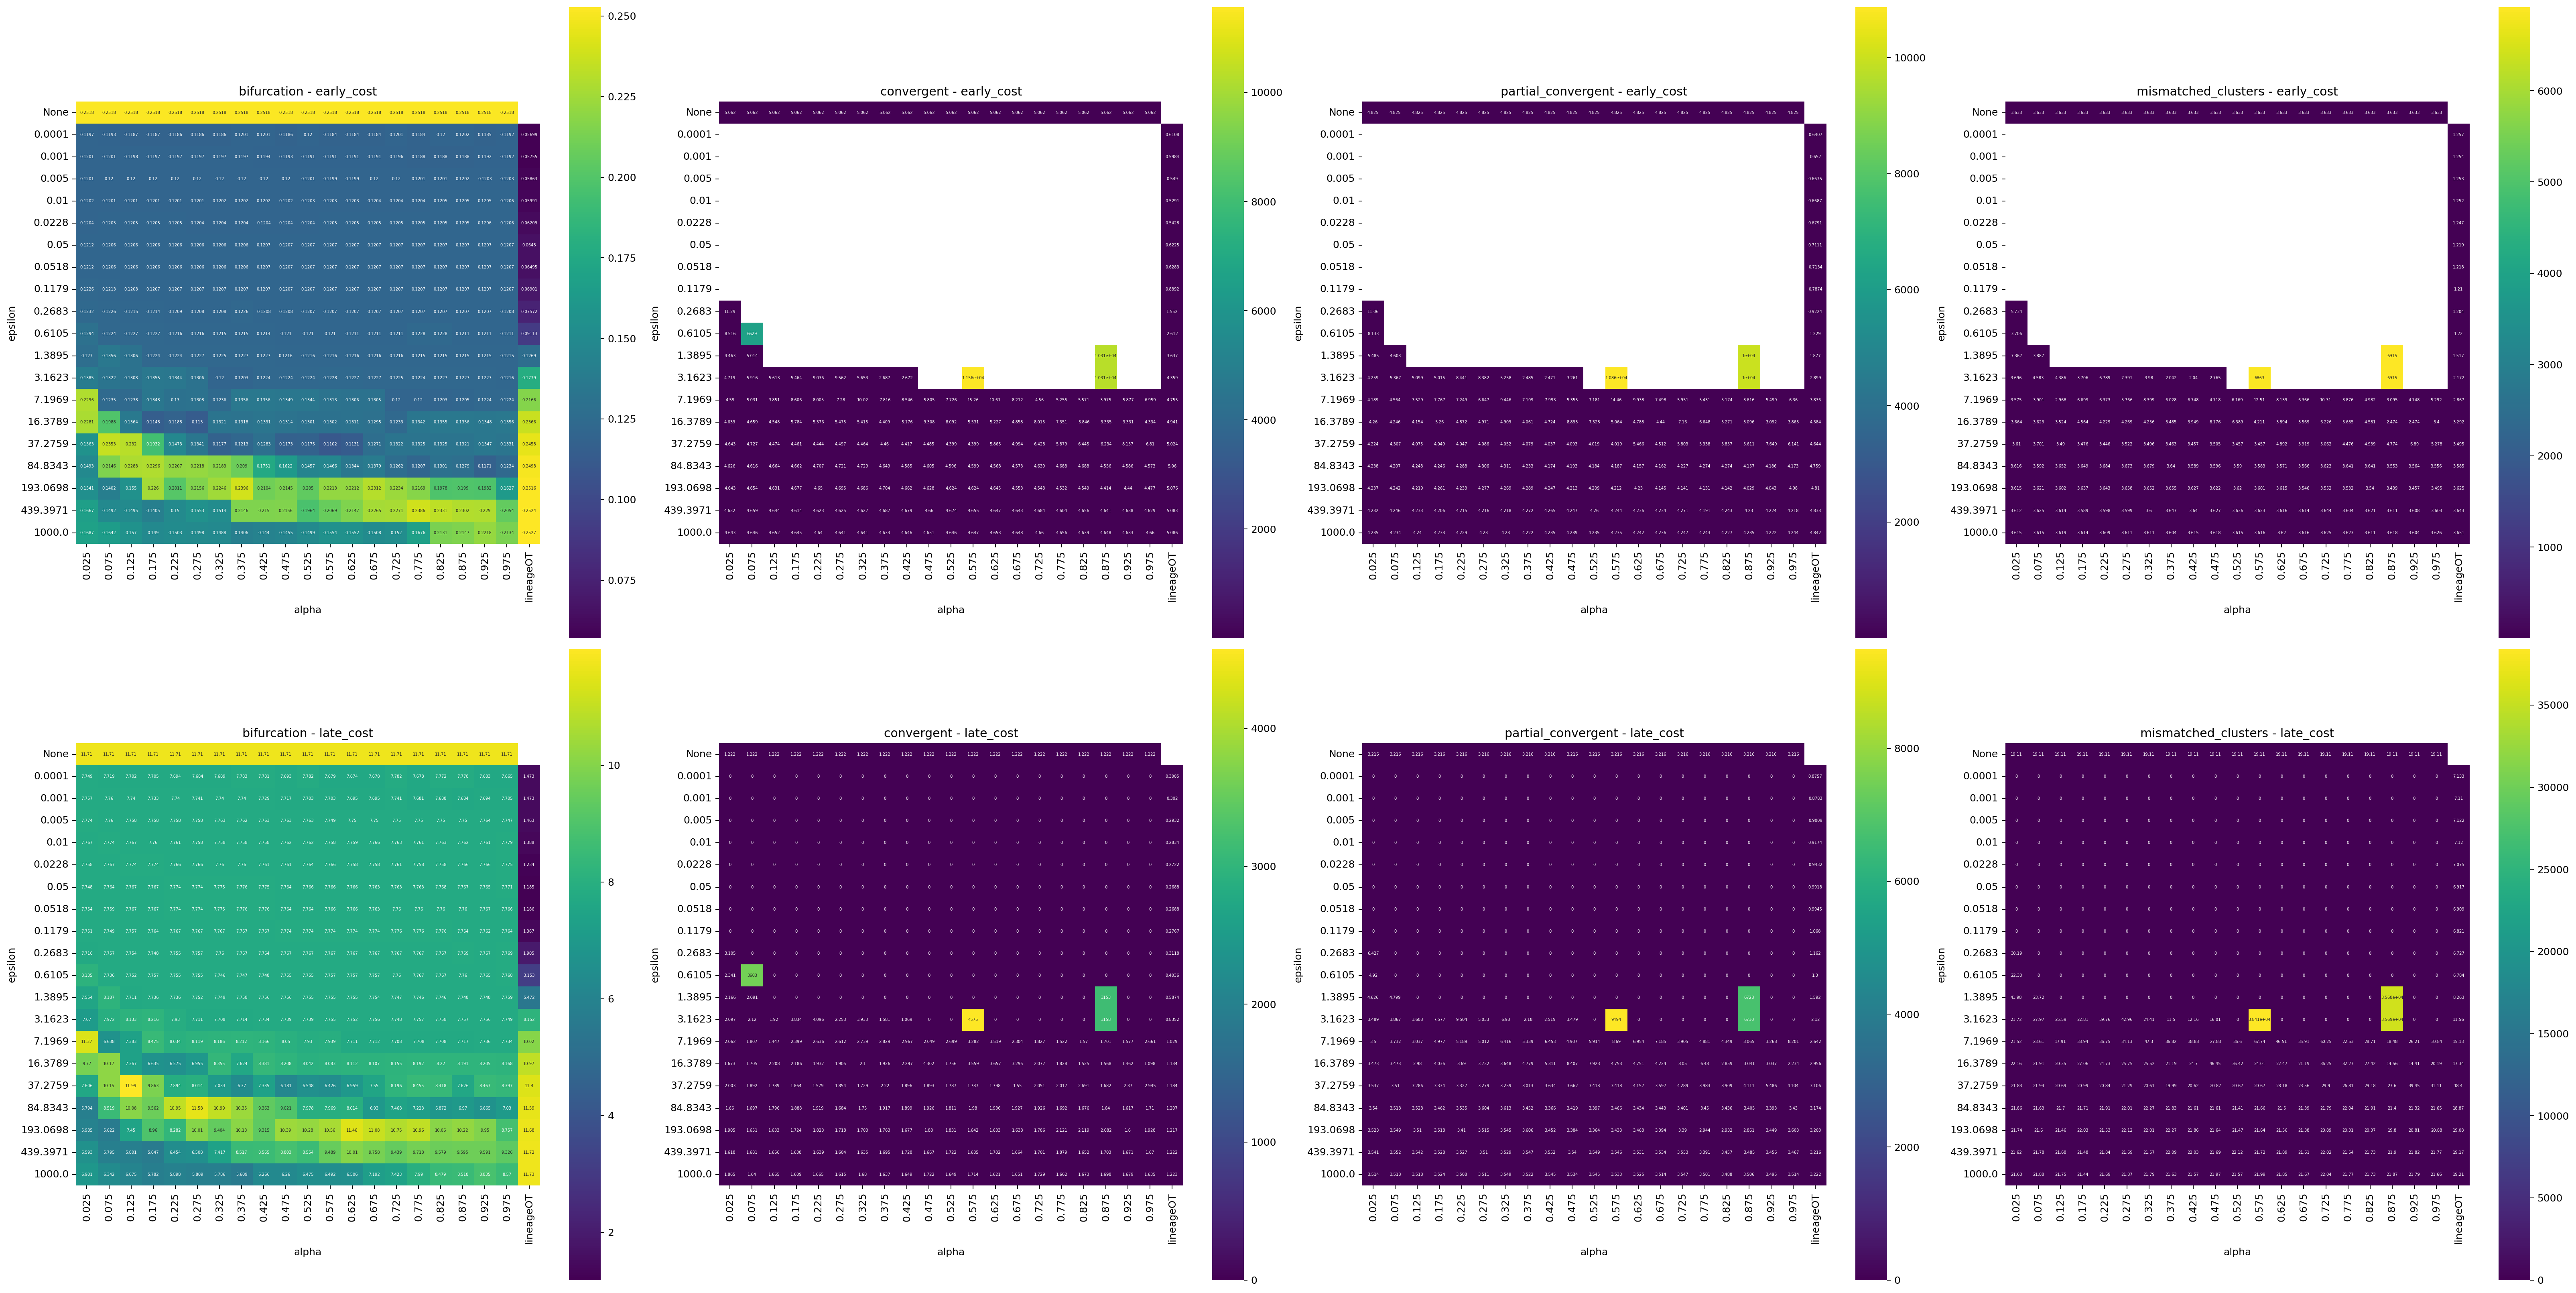

In [15]:
plot(res, annot_kws={"fontsize": 4}, square=True, figsize=(36, 18), fname='default_bench_new.pdf')

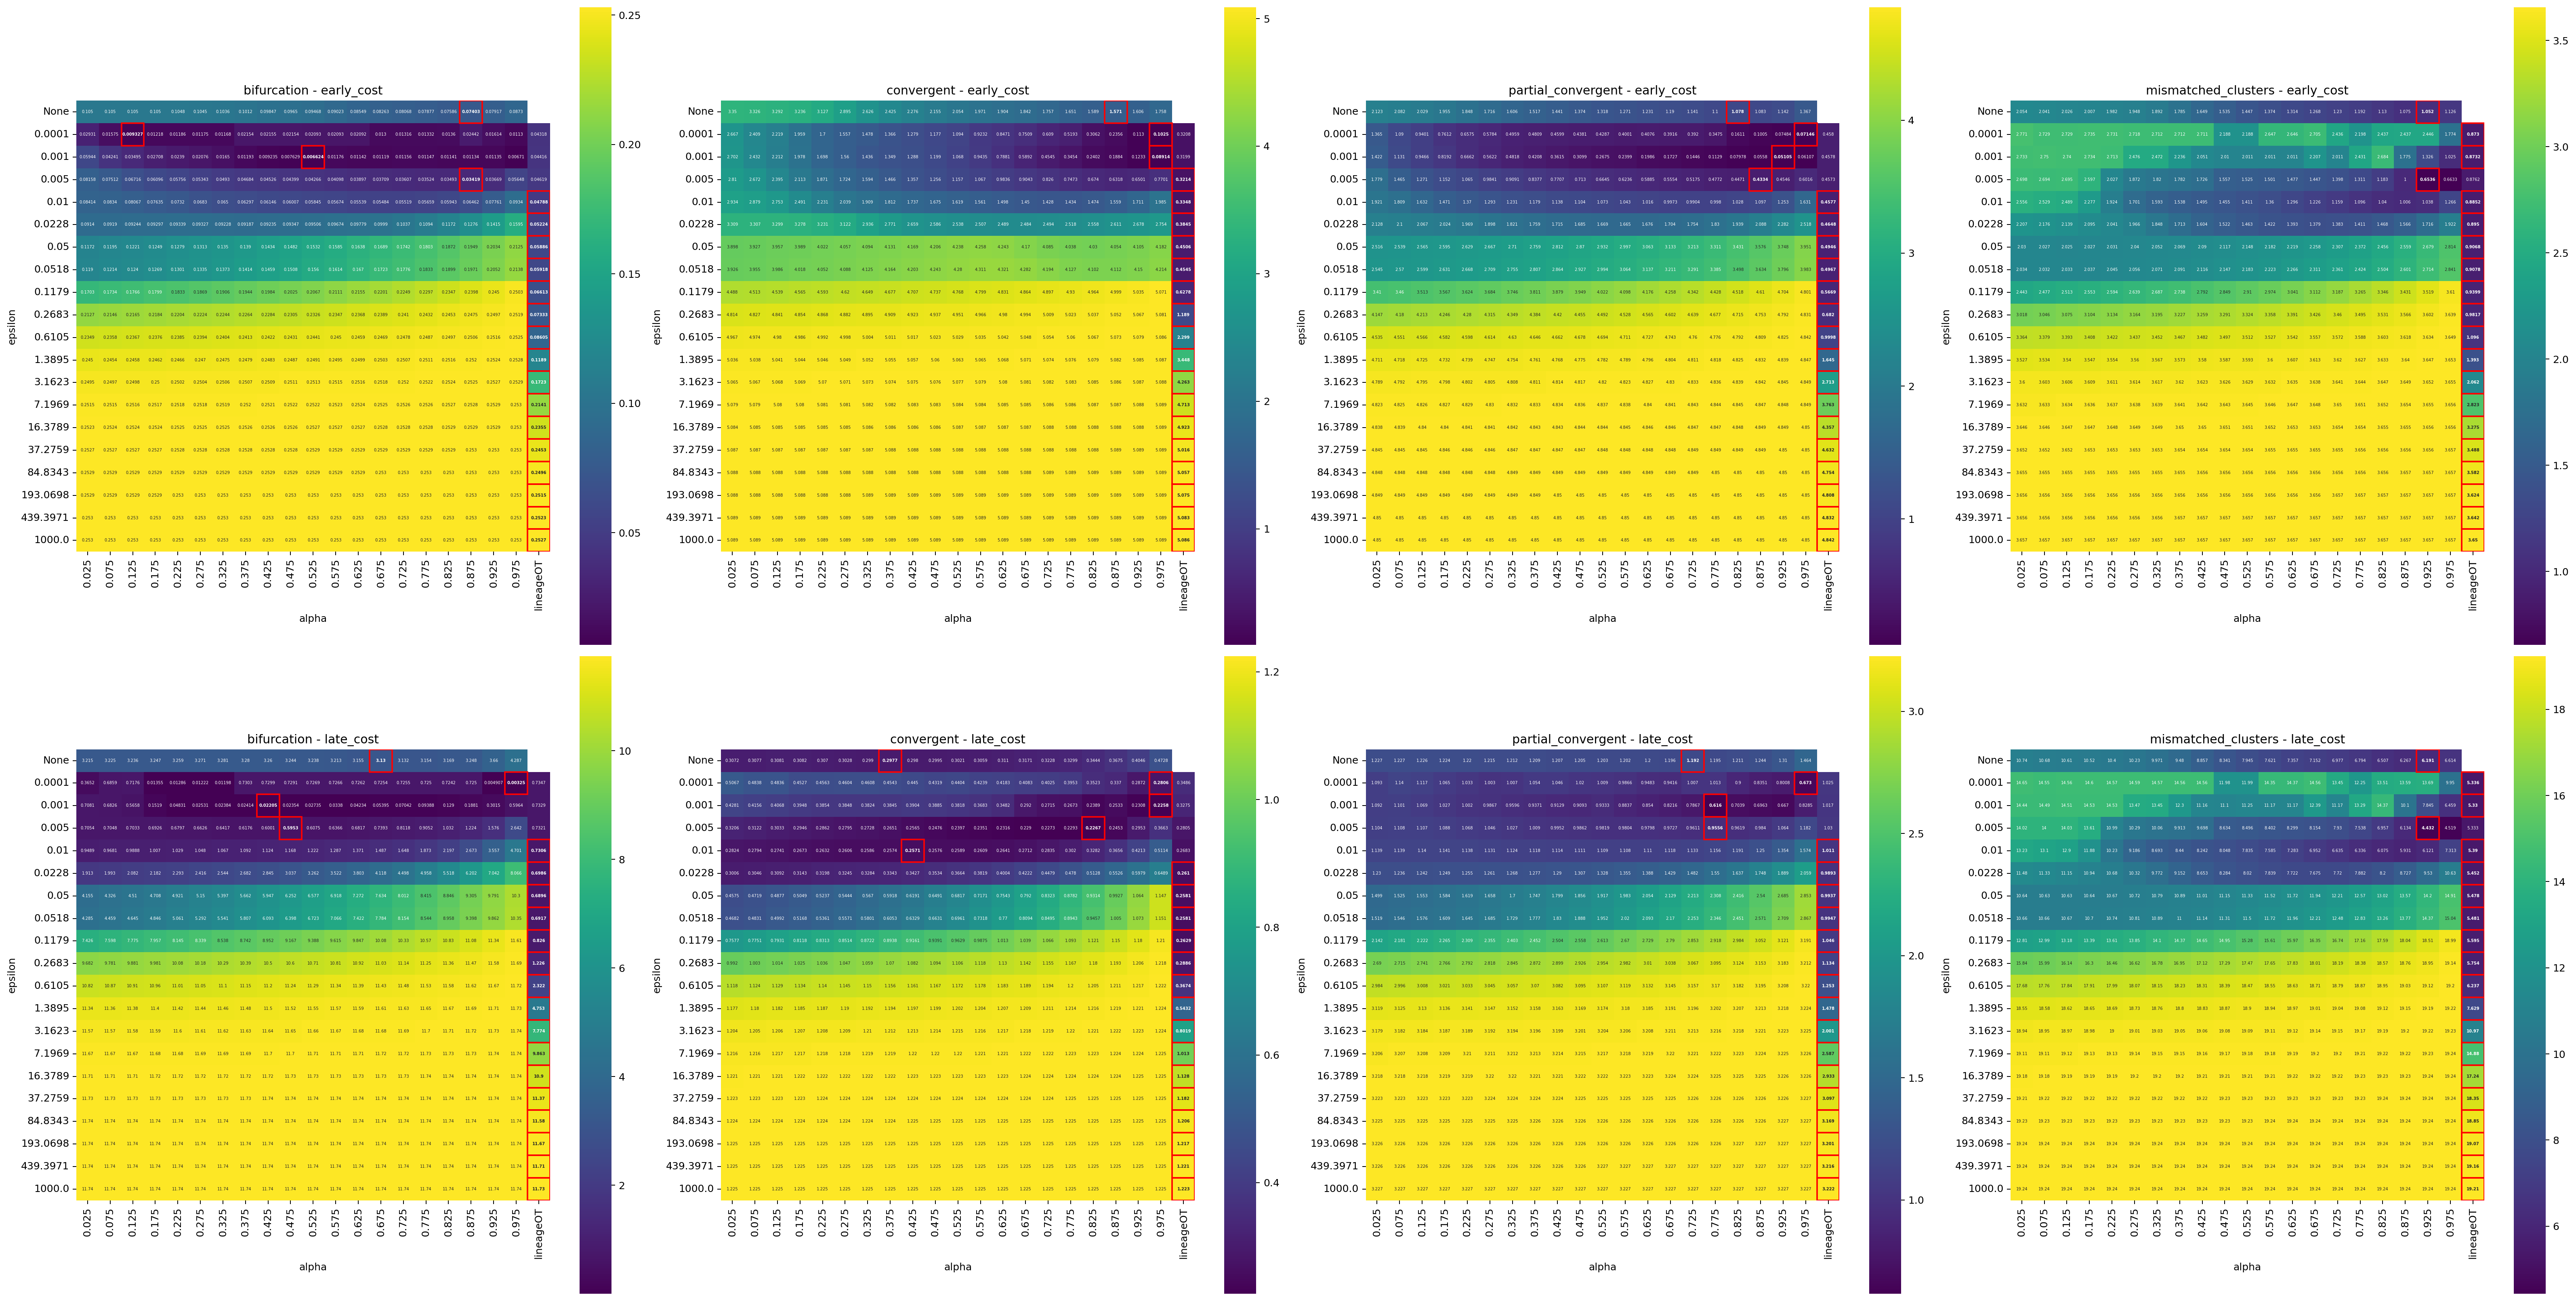

In [10]:
# old
plot(res, annot_kws={"fontsize": 4}, square=True, figsize=(36, 18), fname='default_bench_new.pdf')